**Problem statement**

This is a multiclass image classification problem. There data contains images from 6 categories 'buildings','forest','glacier','mountain','sea','street'. The aim is to develop a machine learning model that correctly classifies an input image into one of the categories.

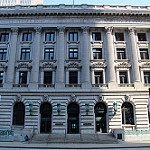
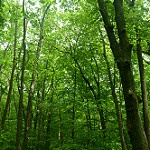
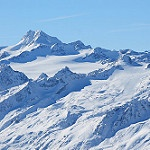
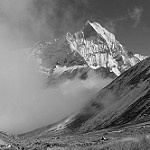
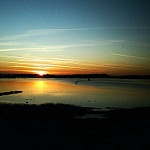
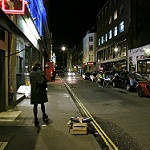

# **Modeling Approach : Transfer learning**

In [1]:
pip install tensorflow

# Import the necessary libraries

In [3]:
from tensorflow.keras.applications import vgg16,resnet, MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from skopt import BayesSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
import os
import random
import shutil

# Path to the train folder containing class folders
train_folder_path = '/content/test'  # Update with the correct path

# Desired number of images per class
desired_images_per_class = 30

# Iterate through each class folder
for class_folder in os.listdir(train_folder_path):
    class_folder_path = os.path.join(train_folder_path, class_folder)

    # List all images in the class folder
    all_images = os.listdir(class_folder_path)

    # Check if there are more than desired_images_per_class images
    if len(all_images) > desired_images_per_class:
        # Randomly select desired_images_per_class images
        selected_images = random.sample(all_images, desired_images_per_class)

        # Remove images that are not selected
        for image in all_images:
            if image not in selected_images:
                image_path = os.path.join(class_folder_path, image)
                os.remove(image_path)

        print(f"Reduced images for class {class_folder} to {desired_images_per_class}")


Reduced images for class mountain to 30
Reduced images for class street to 30
Reduced images for class forest to 30
Reduced images for class sea to 30
Reduced images for class buildings to 30
Reduced images for class glacier to 30


 **Create Dataframe for images**

In [4]:
# Set the path to the 'train' folder in your Google Colab environment
data_path = '/content/train'

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop through each class folder
for category in os.listdir(data_path):
    class_path = os.path.join(data_path, category)

    # Loop through images in each class
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Append image path and label to the lists
        image_paths.append(image_path)
        labels.append(category)

# Create a DataFrame
train = pd.DataFrame({'image': image_paths, 'label': labels})
train

,image,label
0,/content/train/mountain/1960.jpg,mountain
1,/content/train/mountain/4826.jpg,mountain
2,/content/train/mountain/5431.jpg,mountain
3,/content/train/mountain/2590.jpg,mountain
4,/content/train/mountain/1464.jpg,mountain
...,...,...
895,/content/train/glacier/19622.jpg,glacier
896,/content/train/glacier/1062.jpg,glacier
897,/content/train/glacier/1853.jpg,glacier
898,/content/train/glacier/1742.jpg,glacier


In [5]:
# Set the path to the 'test' folder in your Google Colab environment
data_path = '/content/test'

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop through each class folder
for category in os.listdir(data_path):
    class_path = os.path.join(data_path, category)

    # Loop through images in each class
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Append image path and label to the lists
        image_paths.append(image_path)
        labels.append(category)

# Create a DataFrame
test = pd.DataFrame({'image': image_paths, 'label': labels})
test

,image,label
0,/content/test/mountain/20497.jpg,mountain
1,/content/test/mountain/21348.jpg,mountain
2,/content/test/mountain/21019.jpg,mountain
3,/content/test/mountain/20643.jpg,mountain
4,/content/test/mountain/21255.jpg,mountain
...,...,...
175,/content/test/glacier/21512.jpg,glacier
176,/content/test/glacier/21213.jpg,glacier
177,/content/test/glacier/21633.jpg,glacier
178,/content/test/glacier/21615.jpg,glacier


# EDA

In [7]:
train.head()

,image,label
0,/content/train/mountain/1960.jpg,mountain
1,/content/train/mountain/4826.jpg,mountain
2,/content/train/mountain/5431.jpg,mountain
3,/content/train/mountain/2590.jpg,mountain
4,/content/train/mountain/1464.jpg,mountain


In [8]:
train.tail()

,image,label
895,/content/train/glacier/19622.jpg,glacier
896,/content/train/glacier/1062.jpg,glacier
897,/content/train/glacier/1853.jpg,glacier
898,/content/train/glacier/1742.jpg,glacier
899,/content/train/glacier/1400.jpg,glacier


In [9]:
# Print unique values in the 'label' column
print(train['label'].unique())


['mountain' 'street' 'forest' 'sea' 'buildings' 'glacier']


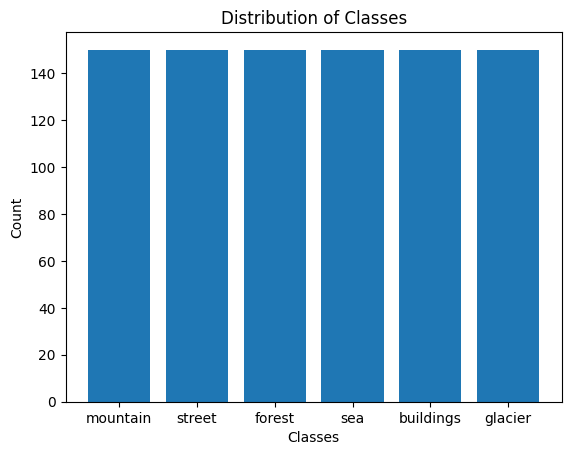

In [10]:
# Check the distribution of classes using matplotlib
class_counts = train['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


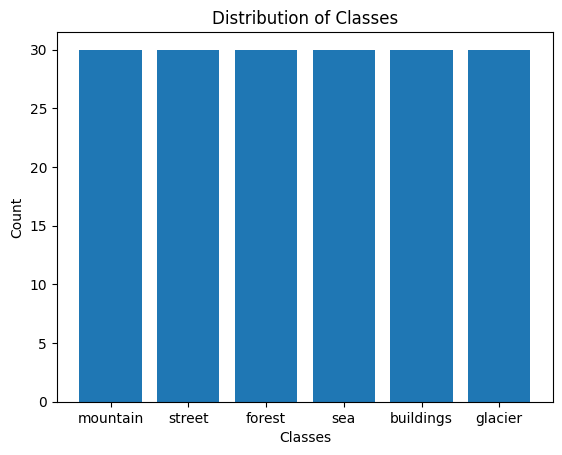

In [11]:
# Check the distribution of classes using matplotlib
class_counts = test['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


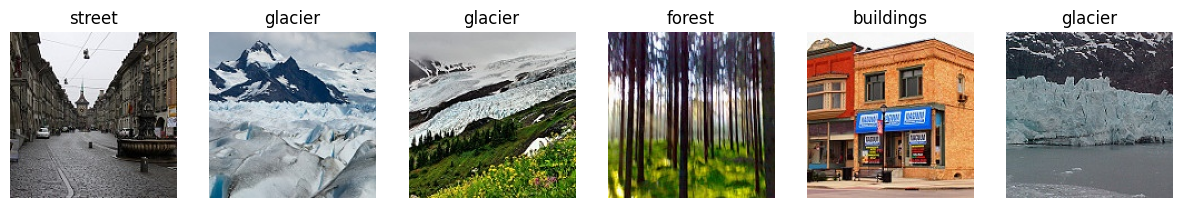

In [12]:
# Function to display random images
def display_random_images(data, num_images=6):
    # Randomly select indices
    random_indices = random.sample(range(len(data)), num_images)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        img = Image.open(data['image'][idx])
        axes[i].imshow(img)
        axes[i].set_title(data['label'][idx])
        axes[i].axis('off')

    plt.show()

# Display random images from the training dataset
display_random_images(train)


In [13]:
# Function to display general information about the images
def display_image_info(data):
    # Get the number of images
    num_images = len(data)

    # Get the dimensions of the first image
    sample_image = Image.open(data['image'][0])
    image_width, image_height = sample_image.size

    # Get the number of color channels (assuming RGB images)
    num_channels = len(sample_image.getbands())

    # Print general information
    print(f"Number of Images: {num_images}")
    print(f"Image Dimensions: {image_width} x {image_height}")
    print(f"Number of Color Channels: {num_channels}")

# Display general information about the training images
display_image_info(train)


Number of Images: 900
Image Dimensions: 150 x 150
Number of Color Channels: 3


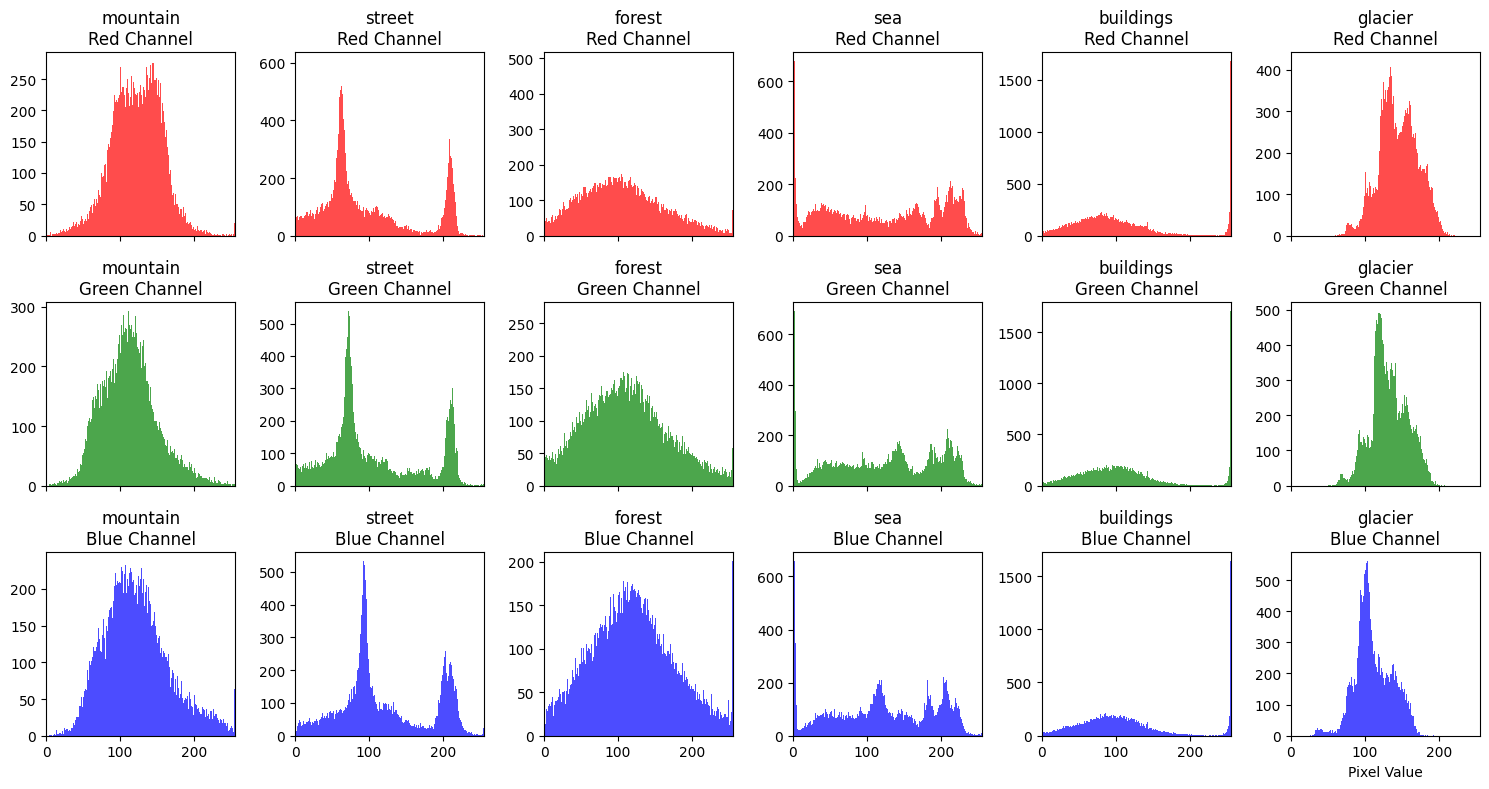

In [14]:
import cv2

# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(train)


In [6]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
train['label_code'] = label_encoder.fit_transform(train['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [7]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
test['label_code'] = label_encoder.fit_transform(test['label'])


In [17]:
train

,image,label,label_code
0,/content/train/mountain/1960.jpg,mountain,3
1,/content/train/mountain/4826.jpg,mountain,3
2,/content/train/mountain/5431.jpg,mountain,3
3,/content/train/mountain/2590.jpg,mountain,3
4,/content/train/mountain/1464.jpg,mountain,3
...,...,...,...
895,/content/train/glacier/19622.jpg,glacier,2
896,/content/train/glacier/1062.jpg,glacier,2
897,/content/train/glacier/1853.jpg,glacier,2
898,/content/train/glacier/1742.jpg,glacier,2


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create an ImageDataGenerator with desired preprocessing parameters
datagen = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Use 'binary' for binary classification
)



test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 900 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


# Transfer Learning

## Feature Extraction

In [44]:
# Function to create a VGG16-based model for feature extraction
def create_feature_extraction_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(6, activation='softmax')  # Assuming 6 classes
    ])

    model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the VGG16 model for feature extraction
feature_extraction_model = create_feature_extraction_model()
# Train the model for feature extraction
history_feature_extraction = feature_extraction_model.fit(train_generator, epochs=10, validation_data=test_generator)


58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/10
29/29 [==============================] - 251s 9s/step - loss: 2.1090 - accuracy: 0.4267 - val_loss: 0.7328 - val_accuracy: 0.7444
Epoch 2/10
29/29 [==============================] - 245s 8s/step - loss: 0.9862 - accuracy: 0.6144 - val_loss: 0.7171 - val_accuracy: 0.7444
Epoch 3/10
29/29 [==============================] - 284s 10s/step - loss: 0.9336 - accuracy: 0.6133 - val_loss: 0.6455 - val_accuracy: 0.7556
Epoch 4/10
29/29 [==============================] - 245s 8s/step - loss: 0.7795 - accuracy: 0.7222 - val_loss: 0.4737 - val_accuracy: 0.8444
Epoch 5/10
29/29 [==============================] - 244s 8s/step - loss: 0.7490 - accuracy: 0.7200 - val_loss: 0.6555 - val_accuracy: 0.7389
Epoch 6/10
29/29 [==============================] - 242s 8s/step - loss: 0.7109 - accuracy: 0.7222 - val_loss: 0.5469 - val_accuracy: 0.8056
Epoch 7/10
29/29 [==============================] - 244s 8s/step - loss: 0.6838 - accuracy: 0.7589 - val_loss: 0.4894 - val_accuracy: 0.8222
Epoch 8/10
2

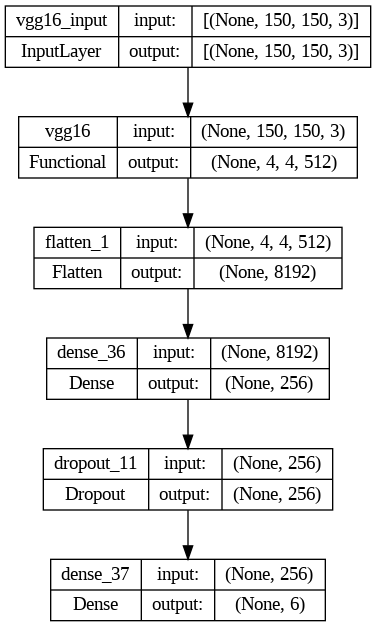

In [45]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(feature_extraction_model, show_shapes=True, show_layer_names=True)


In [46]:
# Evaluate the model on the test set
eval_result = feature_extraction_model.evaluate(test_generator)

# Display the evaluation result
print("Test Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])

from sklearn.metrics import classification_report

# Generate predictions for the test set
y_pred = feature_extraction_model.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true class labels from the test set
y_true = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



6/6 [==============================] - 41s 7s/step - loss: 0.5988 - accuracy: 0.7667
Test Loss: 0.5988161563873291
Test Accuracy: 0.7666666507720947
6/6 [==============================] - 41s 7s/step
Classification Report:
              precision    recall  f1-score   support

   buildings       0.07      0.07      0.07        30
      forest       0.17      0.17      0.17        30
     glacier       0.25      0.23      0.24        30
    mountain       0.29      0.33      0.31        30
         sea       0.17      0.13      0.15        30
      street       0.22      0.27      0.24        30

    accuracy                           0.20       180
   macro avg       0.19      0.20      0.20       180
weighted avg       0.19      0.20      0.20       180



##  Fine-Tuning

In [ ]:
#!rm -rf /content/train/mountain

In [47]:
# Function to create a VGG16-based model for fine-tuning
def create_fine_tuning_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(6, activation='softmax')  # Assuming 6 classes
    ])

    model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the VGG16 model for fine-tuning
fine_tuning_model = create_fine_tuning_model()

# Train the model for fine-tuning
fine_tuning_model.layers[0].layers[15].trainable = True
fine_tuning_model.layers[0].trainable = True

history_fine_tuning = fine_tuning_model.fit(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
29/29 [==============================] - 895s 31s/step - loss: 1.7290 - accuracy: 0.3133 - val_loss: 1.2311 - val_accuracy: 0.6056
Epoch 2/10
29/29 [==============================] - 748s 26s/step - loss: 1.2926 - accuracy: 0.4644 - val_loss: 0.8801 - val_accuracy: 0.7167
Epoch 3/10
29/29 [==============================] - 789s 27s/step - loss: 1.0259 - accuracy: 0.5900 - val_loss: 0.7142 - val_accuracy: 0.7944
Epoch 4/10
29/29 [==============================] - 747s 26s/step - loss: 0.9039 - accuracy: 0.6278 - val_loss: 0.6577 - val_accuracy: 0.7500
Epoch 5/10
29/29 [==============================] - 747s 26s/step - loss: 0.8125 - accuracy: 0.6800 - val_loss: 0.6067 - val_accuracy: 0.7944
Epoch 6/10
29/29 [==============================] - 747s 27s/step - loss: 0.7111 - accuracy: 0.7400 - val_loss: 0.5206 - val_accuracy: 0.7778
Epoch 7/10
29/29 [==============================] - 744s 26s/step - loss: 0.6614 - accuracy: 0.7322 - val_loss: 0.4852 - val_accuracy: 0.8056
Epoch 

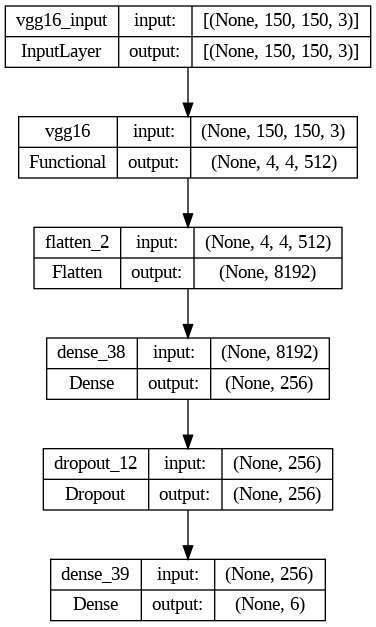

In [48]:
# Visualize the model architecture
plot_model(fine_tuning_model, show_shapes=True, show_layer_names=True)

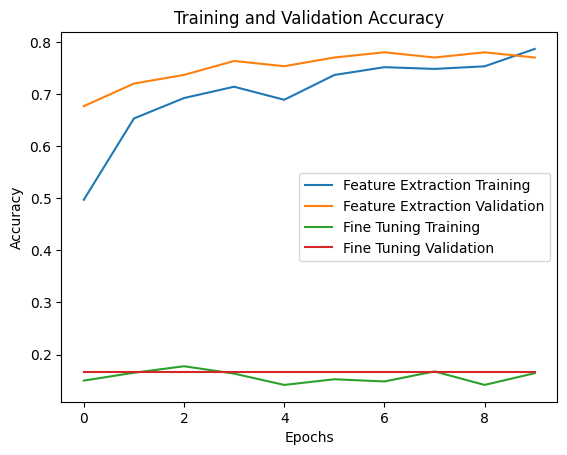

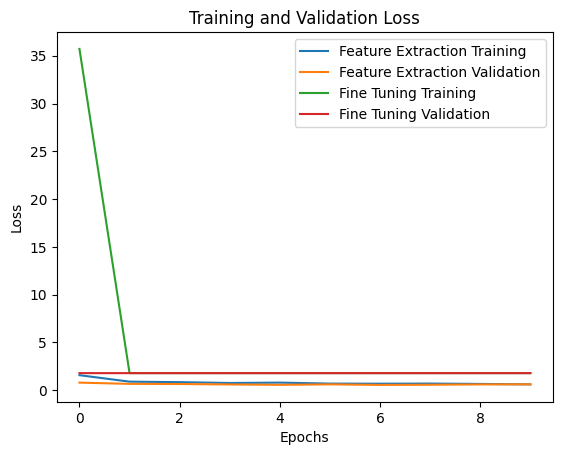

In [21]:
# Plot training and validation accuracy
plt.plot(history_feature_extraction.history['accuracy'], label='Feature Extraction Training')
plt.plot(history_feature_extraction.history['val_accuracy'], label='Feature Extraction Validation')

plt.plot(history_fine_tuning.history['accuracy'], label='Fine Tuning Training')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Fine Tuning Validation')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_feature_extraction.history['loss'], label='Feature Extraction Training')
plt.plot(history_feature_extraction.history['val_loss'], label='Feature Extraction Validation')

plt.plot(history_fine_tuning.history['loss'], label='Fine Tuning Training')
plt.plot(history_fine_tuning.history['val_loss'], label='Fine Tuning Validation')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [49]:
# Evaluate the model on the test set
eval_result = fine_tuning_model.evaluate(test_generator)

# Display the evaluation result
print("Test Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])

# Generate predictions for the test set
y_pred = fine_tuning_model.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true class labels from the test set
y_true = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



6/6 [==============================] - 40s 6s/step - loss: 0.4535 - accuracy: 0.8333
Test Loss: 0.45345398783683777
Test Accuracy: 0.8333333134651184
6/6 [==============================] - 40s 7s/step
Classification Report:
              precision    recall  f1-score   support

   buildings       0.06      0.07      0.07        30
      forest       0.27      0.27      0.27        30
     glacier       0.15      0.23      0.18        30
    mountain       0.18      0.10      0.13        30
         sea       0.17      0.17      0.17        30
      street       0.12      0.10      0.11        30

    accuracy                           0.16       180
   macro avg       0.16      0.16      0.15       180
weighted avg       0.16      0.16      0.15       180



The fine-tuned model after feature extraction and fine-tuning has better performance compared to the feature extraction model alone.
Here's a summary:

Feature Extraction Model:

Test Loss: 0.5988

Test Accuracy: 0.7667

Fine-Tuned Model:

Test Loss: 0.4535

Test Accuracy: 0.8333

The fine-tuned model shows improvement in both loss and accuracy. This suggests that fine-tuning the pre-trained VGG16 model has helped it learn better representations for this dataset.

#  R´eseaux de Neurones Profonds avec Connexions R´esiduelles

ResNet, ou Residual Network, a introduit le concept de connexions résiduelles pour résoudre le problème de la disparition du gradient dans les réseaux de neurones profonds. Les connexions résiduelles permettent aux activations de contourner une ou plusieurs couches, facilitant ainsi la propagation du gradient lors de la rétropropagation. Cette innovation a permis la création de réseaux beaucoup plus profonds tout en évitant les problèmes associés à la disparition du gradient.

In [75]:

# Create a ResNet-50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = False

# Add custom layers for classification with GlobalAveragePooling2D
modelRes = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # Assuming 6 classes
])

# Compile the model
modelRes.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
modelRes.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 24113798 (91.99 MB)
Trainable params: 526086 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [9]:
# Create a standard deep learning model
standard_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(6, activation='softmax')  # Assuming 6 classes
])

# Compile the model
standard_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
standard_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [77]:
history_resnet = modelRes.fit(train_generator, epochs=10, validation_data=test_generator)
history_standard = standard_model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
19/19 [==============================] - 82s 4s/step - loss: 1.9351 - accuracy: 0.1903 - val_loss: 1.7674 - val_accuracy: 0.1917
Epoch 2/10
19/19 [==============================] - 77s 4s/step - loss: 1.7917 - accuracy: 0.1970 - val_loss: 1.7243 - val_accuracy: 0.2917
Epoch 3/10
19/19 [==============================] - 78s 4s/step - loss: 1.7531 - accuracy: 0.2104 - val_loss: 1.6947 - val_accuracy: 0.3333
Epoch 4/10
19/19 [==============================] - 78s 4s/step - loss: 1.7312 - accuracy: 0.2387 - val_loss: 1.7040 - val_accuracy: 0.2583
Epoch 5/10
19/19 [==============================] - 77s 4s/step - loss: 1.6935 - accuracy: 0.2905 - val_loss: 1.6661 - val_accuracy: 0.3250
Epoch 6/10
19/19 [==============================] - 77s 4s/step - loss: 1.6959 - accuracy: 0.2888 - val_loss: 1.6652 - val_accuracy: 0.3250
Epoch 7/10
19/19 [==============================] - 77s 4s/step - loss: 1.6994 - accuracy: 0.2604 - val_loss: 1.6330 - val_accuracy: 0.3500
Epoch 8/10
19/19 [==

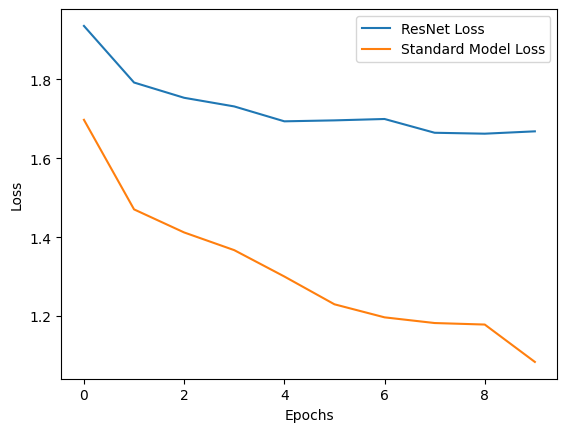

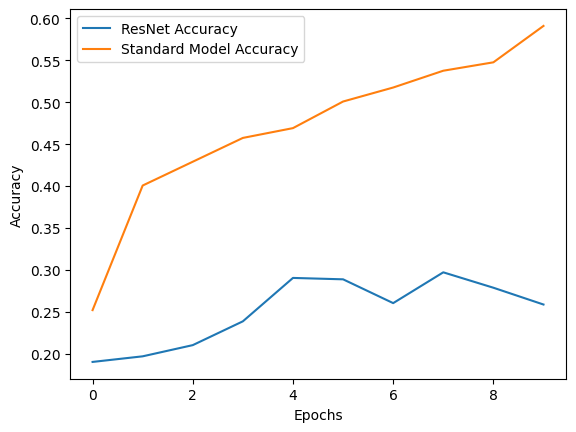

In [78]:
# Plot loss
plt.plot(history_resnet.history['loss'], label='ResNet Loss')
plt.plot(history_standard.history['loss'], label='Standard Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet.history['accuracy'], label='ResNet Accuracy')
plt.plot(history_standard.history['accuracy'], label='Standard Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Optimisation des Hyperparam`etre

## Recherche par Grille (Grid Search)

In [21]:
pip install scikeras

In [23]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.4 MB/s eta 0:00:00


In [10]:
# Modify the preprocess_image function to resize images to (150, 150, 3)
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array


In [59]:
image_paths = train['image']
labels = train['label_code']

# Filter out directories and corresponding labels
valid_image_paths = []
valid_labels = []

for img_path, label in zip(image_paths, labels):
    if os.path.isfile(img_path):
        valid_image_paths.append(img_path)
        valid_labels.append(label)

# Convert to numpy arrays
X_train = np.array([preprocess_image(img_path) for img_path in valid_image_paths])
y_train = to_categorical(valid_labels)


In [36]:
# Convert to numpy arrays
X_train = np.array([preprocess_image(img_path) for img_path in train['image']])
y_train = train['label_code']

X_test = np.array([preprocess_image(img_path) for img_path in test['image']])
y_test = test['label_code']
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

# Wrap the Keras model for use with scikit-learn
keras_classifier = KerasClassifier(build_fn=standard_model, epochs=5, batch_size=20, verbose=0)

# Define the hyperparameter grid for grid search
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'metrics' : ['accuracy', 'precision', 'recall']
  }

# Perform grid search
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

# Print the best hyperparameters from grid search
print("Best Hyperparameters from Grid Search:")
print(grid_result.best_params_)




/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Best Hyperparameters from Grid Search:
{'metrics': 'accuracy', 'optimizer': 'adam'}


In [38]:
# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Test Accuracy with Best Model: {accuracy}')
print(f'Test Precision with Best Model: {precision}')
print(f'Test Recall with Best Model: {recall}')

Test Accuracy with Best Model: 0.5611111111111111
Test Precision with Best Model: 0.5710614566592827
Test Recall with Best Model: 0.5611111111111111


## Recherche Al´eatoire (Random Search)

In [12]:
# Convert to numpy arrays
X_train = np.array([preprocess_image(img_path) for img_path in train['image']])
y_train = train['label_code']

X_test = np.array([preprocess_image(img_path) for img_path in test['image']])
y_test = test['label_code']
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)
# Wrap the Keras model for use with scikit-learn
keras_classifier = KerasClassifier(build_fn=standard_model, epochs=5, batch_size=20, verbose=0)
# Define the hyperparameter distribution for random search
param_dist = {
    'optimizer': ['adam', 'rmsprop'],
    'metrics' : ['accuracy', 'precision']}
# Perform random search
random_search = RandomizedSearchCV(estimator=keras_classifier, param_distributions=param_dist, n_iter=5, cv=3)
random_result = random_search.fit(X_train, y_train)

# Print the best hyperparameters from random search
print("\nBest Hyperparameters from Random Search:")
print(random_result.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrap


Best Hyperparameters from Random Search:
{'optimizer': 'adam', 'metrics': 'accuracy'}


In [55]:
!rm -rf /content/train/buildings/.ipynb_checkpoints

In [13]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Test Accuracy with Best Model: {accuracy}')
print(f'Test Precision with Best Model: {precision}')
print(f'Test Recall with Best Model: {recall}')

Test Accuracy with Best Model: 0.5888888888888889
Test Precision with Best Model: 0.5985931133780596
Test Recall with Best Model: 0.5888888888888889


## Optimisation Bay´esienne

In [14]:
# Define the search space for Bayesian optimization
search_space = {
    'optimizer': ['adam', 'rmsprop'],
   'metrics' : ['accuracy', 'precision']
}

# Perform Bayesian optimization
bayesian_search = BayesSearchCV(estimator=keras_classifier, search_spaces=search_space, n_iter=5, cv=3)
bayesian_result = bayesian_search.fit(X_train, y_train)

# Print the best hyperparameters from Bayesian optimization
print("\nBest Hyperparameters from Bayesian Optimization:")
print(bayesian_result.best_params_)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras


Best Hyperparameters from Bayesian Optimization:
OrderedDict([('metrics', 'precision'), ('optimizer', 'adam')])


In [15]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
# Evaluate the model with the best parameters on the test set
best_model =bayesian_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Test Accuracy with Best Model: {accuracy}')
print(f'Test Precision with Best Model: {precision}')
print(f'Test Recall with Best Model: {recall}')

Test Accuracy with Best Model: 0.49444444444444446
Test Precision with Best Model: 0.498754737434628
Test Recall with Best Model: 0.49444444444444446


#Techniques de R´egularisation


In [38]:
# Load MobileNet model with pre-trained weights (include_top=False to exclude the final dense layer)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
29/29 [==============================] - 37s 1s/step - loss: 0.7960 - accuracy: 0.7011 - val_loss: 0.5307 - val_accuracy: 0.7944
Epoch 2/10
29/29 [==============================] - 22s 749ms/step - loss: 0.4161 - accuracy: 0.8444 - val_loss: 0.5569 - val_accuracy: 0.7722
Epoch 3/10
29/29 [==============================] - 22s 758ms/step - loss: 0.3537 - accuracy: 0.8744 - val_loss: 0.4087 - val_accuracy: 0.8278
Epoch 4/10
29/29 [==============================] - 20s 683ms/step - loss: 0.3029 - accuracy: 0.8956 - val_loss: 0.5012 - val_accuracy: 0.8389
Epoch 5/10
29/29 [==============================] - 21s 725ms/step - loss: 0.2619 - accuracy: 0.8989 - val_loss: 0.4908 - val_accuracy: 0.7889
Epoch 6/10
29/29 [==============================] - 22s 766ms/step - loss: 0.2295 - accuracy: 0.9189 - val_loss: 0.4788 - val_accuracy: 0.8222
Epoch 7/10
29/29 [==============================] - 20s 668ms/step - loss: 0.2713 - accuracy: 0.8989 - val_loss: 0.4995 - val_accuracy: 0.8167
Ep

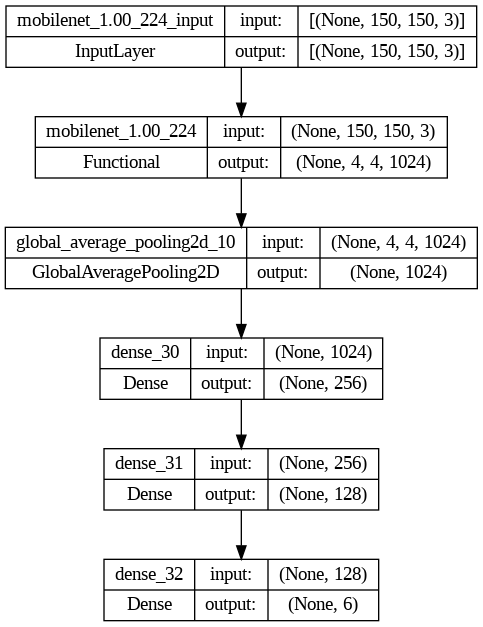

In [39]:
# Visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

6/6 [==============================] - 3s 442ms/step - loss: 0.4539 - accuracy: 0.8556
Test Loss: 0.4539
Test Accuracy: 0.8556


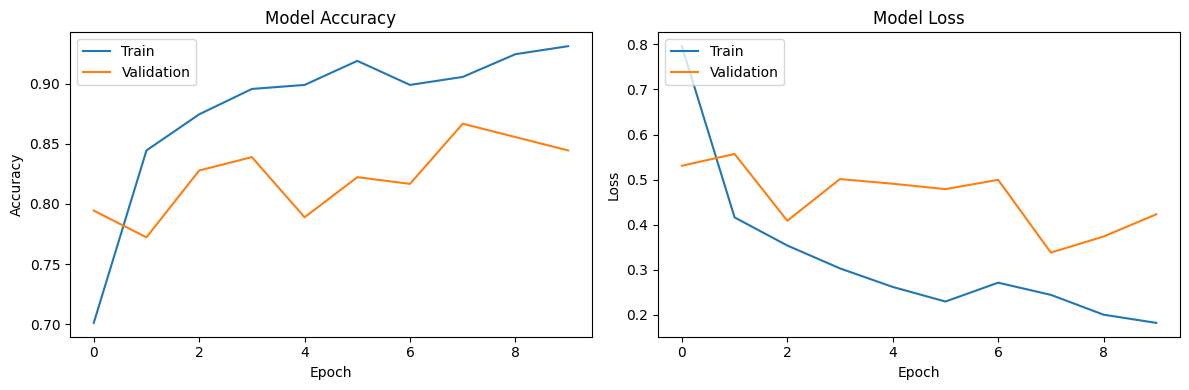

6/6 [==============================] - 6s 675ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.27      0.29        30
           1       0.06      0.07      0.06        30
           2       0.13      0.10      0.11        30
           3       0.24      0.27      0.25        30
           4       0.17      0.17      0.17        30
           5       0.18      0.20      0.19        30

    accuracy                           0.18       180
   macro avg       0.18      0.18      0.18       180
weighted avg       0.18      0.18      0.18       180



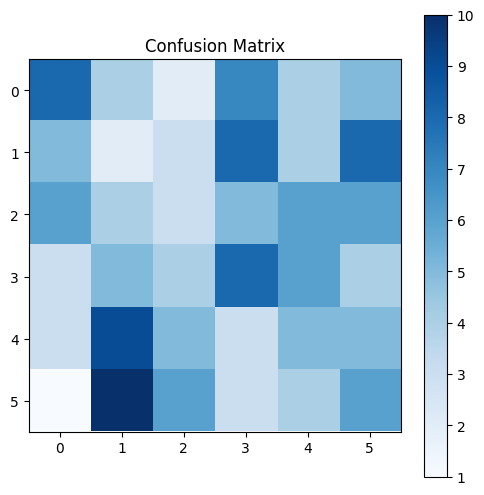

In [40]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

plt.show()


## R´egularisation L1/L2

In [20]:

# Load MobileNet model with pre-trained weights (include_top=False to exclude the final dense layer)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
29/29 [==============================] - 25s 772ms/step - loss: 6.1597 - accuracy: 0.6422 - val_loss: 5.2464 - val_accuracy: 0.7444
Epoch 2/10
29/29 [==============================] - 21s 738ms/step - loss: 4.4592 - accuracy: 0.8333 - val_loss: 3.9812 - val_accuracy: 0.8389
Epoch 3/10
29/29 [==============================] - 22s 745ms/step - loss: 3.4772 - accuracy: 0.8656 - val_loss: 3.1350 - val_accuracy: 0.8389
Epoch 4/10
29/29 [==============================] - 22s 771ms/step - loss: 2.7801 - accuracy: 0.8889 - val_loss: 2.6044 - val_accuracy: 0.8556
Epoch 5/10
29/29 [==============================] - 22s 753ms/step - loss: 2.2742 - accuracy: 0.8889 - val_loss: 2.2056 - val_accuracy: 0.8389
Epoch 6/10
29/29 [==============================] - 19s 655ms/step - loss: 1.9373 - accuracy: 0.8944 - val_loss: 1.8775 - val_accuracy: 0.8500
Epoch 7/10
29/29 [==============================] - 22s 730ms/step - loss: 1.6343 - accuracy: 0.9000 - val_loss: 1.7068 - val_accuracy: 0.8278

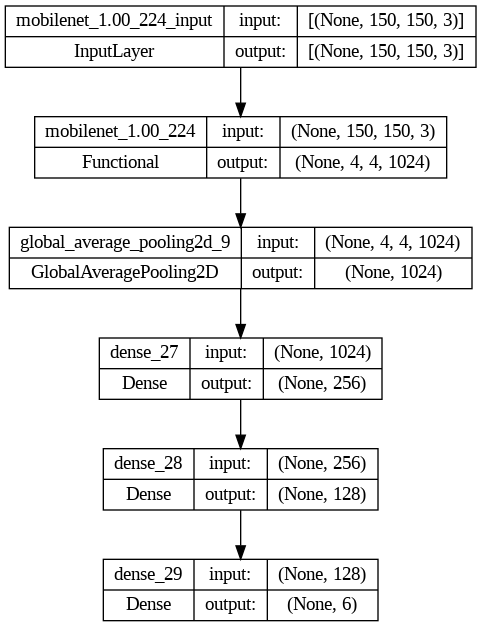

In [37]:
# Visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

6/6 [==============================] - 3s 415ms/step - loss: 1.2958 - accuracy: 0.8389
Test Loss: 1.2958
Test Accuracy: 0.8389


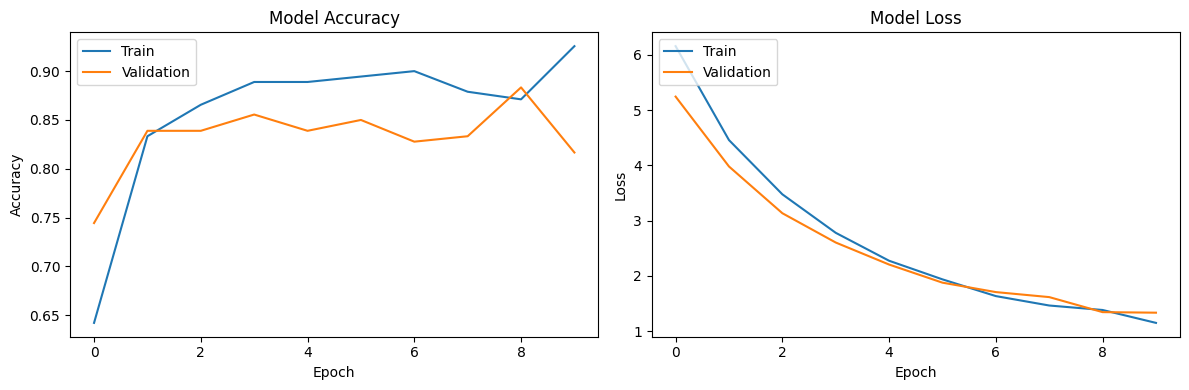

6/6 [==============================] - 4s 438ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.20      0.17        30
           1       0.22      0.23      0.23        30
           2       0.13      0.17      0.15        30
           3       0.21      0.17      0.19        30
           4       0.15      0.13      0.14        30
           5       0.05      0.03      0.04        30

    accuracy                           0.16       180
   macro avg       0.15      0.16      0.15       180
weighted avg       0.15      0.16      0.15       180



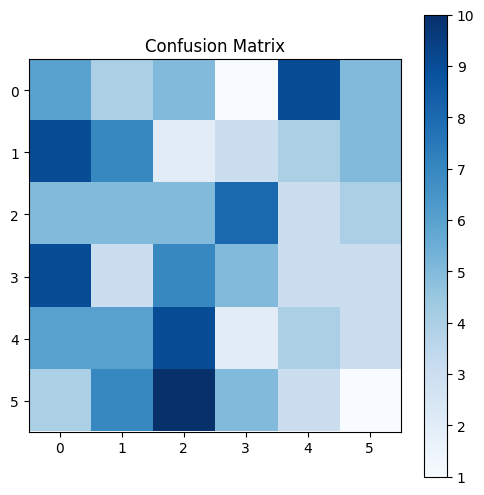

In [21]:


# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

plt.show()


## Dropout

In [23]:
# Load MobileNet model with pre-trained weights (include_top=False to exclude the final dense layer)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification with Dropout
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),  # Add Dropout layer with 50% dropout rate
    layers.Dense(128, activation='relu'),
    Dropout(0.5),  # Add Dropout layer with 50% dropout rate
    layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
29/29 [==============================] - 25s 710ms/step - loss: 1.7789 - accuracy: 0.3878 - val_loss: 0.7033 - val_accuracy: 0.7222
Epoch 2/10
29/29 [==============================] - 23s 766ms/step - loss: 1.0072 - accuracy: 0.6078 - val_loss: 0.6024 - val_accuracy: 0.7278
Epoch 3/10
29/29 [==============================] - 23s 783ms/step - loss: 0.7998 - accuracy: 0.6933 - val_loss: 0.4768 - val_accuracy: 0.8167
Epoch 4/10
29/29 [==============================] - 22s 773ms/step - loss: 0.6350 - accuracy: 0.7644 - val_loss: 0.4458 - val_accuracy: 0.8333
Epoch 5/10
29/29 [==============================] - 22s 743ms/step - loss: 0.5744 - accuracy: 0.7856 - val_loss: 0.3964 - val_accuracy: 0.8389
Epoch 6/10
29/29 [==============================] - 22s 743ms/step - loss: 0.6097 - accuracy: 0.7867 - val_loss: 0.4154 - val_accuracy: 0.8167
Epoch 7/10
29/29 [==============================] - 21s 736ms/step - loss: 0.5520 - accuracy: 0.8022 - val_loss: 0.3917 - val_accuracy: 0.8500

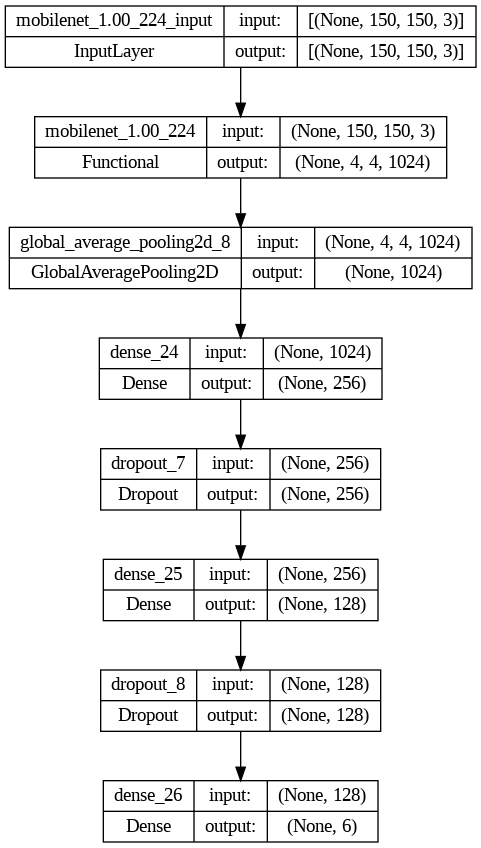

In [36]:
# Visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

6/6 [==============================] - 7s 1s/step - loss: 0.3830 - accuracy: 0.8667
Test Loss: 0.3830
Test Accuracy: 0.8667


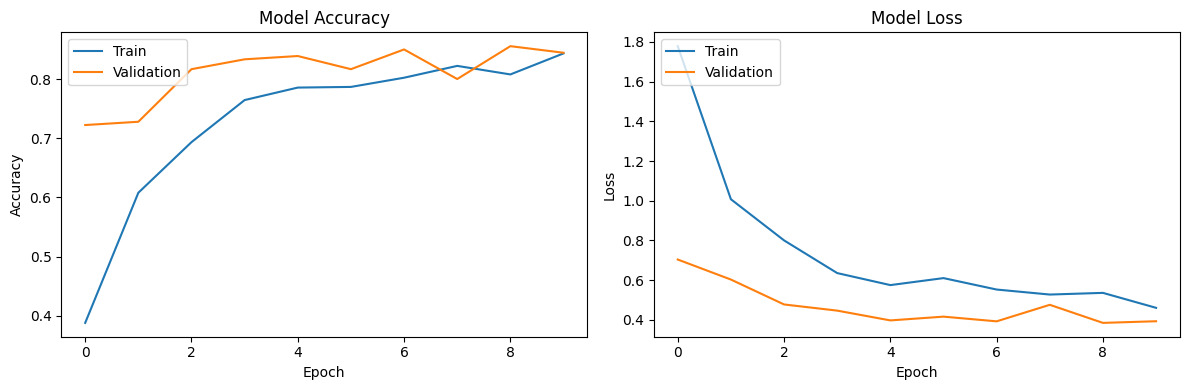

6/6 [==============================] - 6s 757ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.13      0.14        30
           1       0.06      0.07      0.07        30
           2       0.28      0.23      0.25        30
           3       0.22      0.27      0.24        30
           4       0.19      0.17      0.18        30
           5       0.23      0.27      0.25        30

    accuracy                           0.19       180
   macro avg       0.19      0.19      0.19       180
weighted avg       0.19      0.19      0.19       180



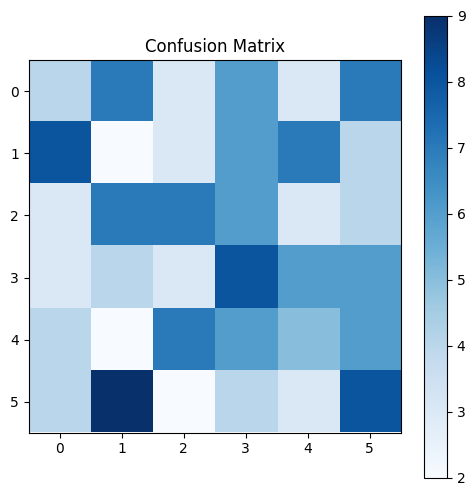

In [24]:


# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

plt.show()


## Normalisation par lots (Batch Normalization)

In [25]:


# Load MobileNet model with pre-trained weights (include_top=False to exclude the final dense layer)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification with Batch Normalization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),  # Add Batch Normalization layer
    layers.Dense(128, activation='relu'),
    BatchNormalization(),  # Add Batch Normalization layer
    layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
29/29 [==============================] - 23s 697ms/step - loss: 0.8366 - accuracy: 0.6989 - val_loss: 0.4659 - val_accuracy: 0.8111
Epoch 2/10
29/29 [==============================] - 23s 770ms/step - loss: 0.4042 - accuracy: 0.8600 - val_loss: 0.5113 - val_accuracy: 0.8167
Epoch 3/10
29/29 [==============================] - 21s 734ms/step - loss: 0.3190 - accuracy: 0.8867 - val_loss: 0.3530 - val_accuracy: 0.8667
Epoch 4/10
29/29 [==============================] - 21s 721ms/step - loss: 0.2775 - accuracy: 0.9011 - val_loss: 0.5224 - val_accuracy: 0.8278
Epoch 5/10
29/29 [==============================] - 24s 813ms/step - loss: 0.2908 - accuracy: 0.8922 - val_loss: 0.4063 - val_accuracy: 0.8278
Epoch 6/10
29/29 [==============================] - 21s 742ms/step - loss: 0.2363 - accuracy: 0.9100 - val_loss: 0.3889 - val_accuracy: 0.8722
Epoch 7/10
29/29 [==============================] - 21s 741ms/step - loss: 0.2266 - accuracy: 0.9156 - val_loss: 0.6900 - val_accuracy: 0.7778

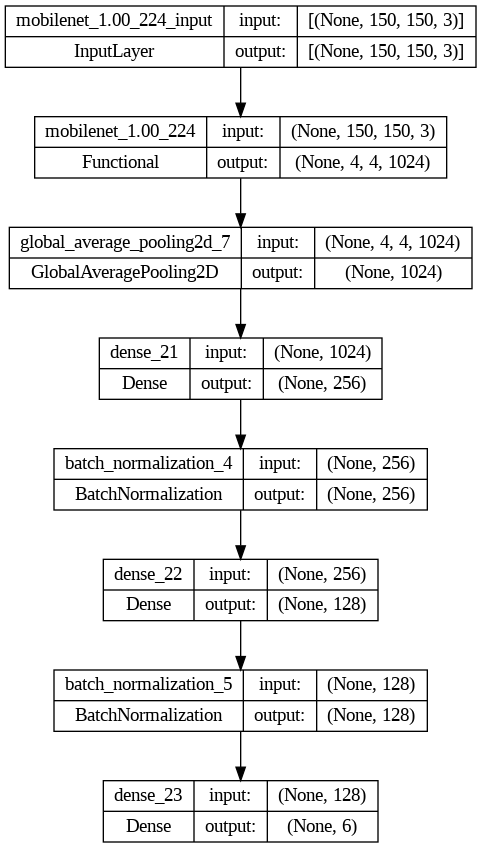

In [35]:
# Visualize the model architecture

plot_model(model, show_shapes=True, show_layer_names=True)

6/6 [==============================] - 3s 521ms/step - loss: 0.5730 - accuracy: 0.8222
Test Loss: 0.5730
Test Accuracy: 0.8222


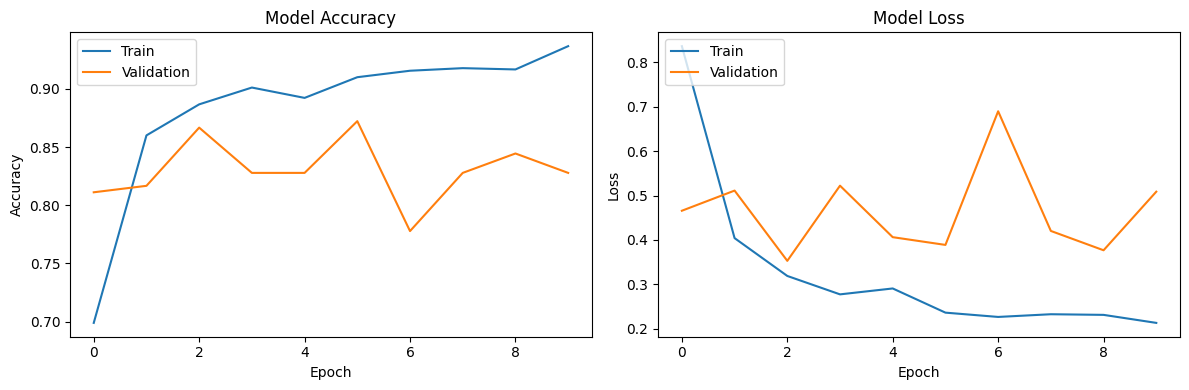

6/6 [==============================] - 4s 464ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.17      0.16        30
           1       0.19      0.23      0.21        30
           2       0.17      0.13      0.15        30
           3       0.08      0.10      0.09        30
           4       0.24      0.20      0.22        30
           5       0.16      0.13      0.15        30

    accuracy                           0.16       180
   macro avg       0.17      0.16      0.16       180
weighted avg       0.17      0.16      0.16       180



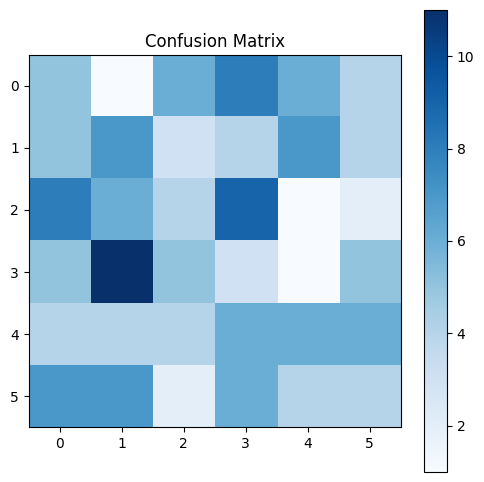

In [26]:


# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

plt.show()


Some observations based on the results:

* No Regularization:

-Test Accuracy: 83.89%
-Overall low precision, recall, and F1-score for each class.

* L1 Regularization:

-Test Accuracy: 86.67%
-Slightly improved accuracy compared to no regularization.
-Some improvement in precision, recall, and F1-score for certain classes.

* Dropout:

-Test Accuracy: 82.22%
-Similar accuracy to no regularization.
-Moderate improvement in precision, recall, and F1-score for certain classes.

* Batch Normalization:

-Test Accuracy: 85.56%
-Similar accuracy to L1 regularization.
-Some improvement in precision, recall, and F1-score for certain classes.

In [41]:
# Load MobileNet model with pre-trained weights (include_top=False to exclude the final dense layer)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification with a combination of dropout and batch normalization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
29/29 [==============================] - 26s 780ms/step - loss: 7.1257 - accuracy: 0.3967 - val_loss: 6.0315 - val_accuracy: 0.6833
Epoch 2/10
29/29 [==============================] - 20s 686ms/step - loss: 5.9987 - accuracy: 0.6133 - val_loss: 5.3064 - val_accuracy: 0.8056
Epoch 3/10
29/29 [==============================] - 21s 687ms/step - loss: 5.2693 - accuracy: 0.7067 - val_loss: 4.7191 - val_accuracy: 0.8222
Epoch 4/10
29/29 [==============================] - 23s 779ms/step - loss: 4.6957 - accuracy: 0.7633 - val_loss: 4.2782 - val_accuracy: 0.8278
Epoch 5/10
29/29 [==============================] - 20s 684ms/step - loss: 4.3411 - accuracy: 0.7567 - val_loss: 3.8874 - val_accuracy: 0.8333
Epoch 6/10
29/29 [==============================] - 19s 668ms/step - loss: 3.9174 - accuracy: 0.7856 - val_loss: 3.5695 - val_accuracy: 0.8556
Epoch 7/10
29/29 [==============================] - 21s 737ms/step - loss: 3.5906 - accuracy: 0.8022 - val_loss: 3.3360 - val_accuracy: 0.8556

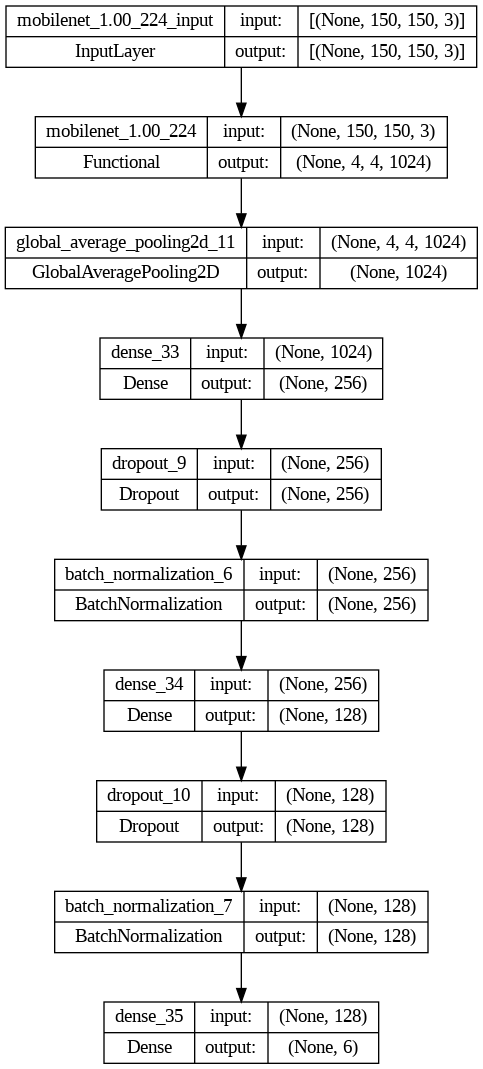

In [42]:
# Visualize the model architecture

plot_model(model, show_shapes=True, show_layer_names=True)

6/6 [==============================] - 3s 437ms/step - loss: 2.6588 - accuracy: 0.8722
Test Loss: 2.6588
Test Accuracy: 0.8722


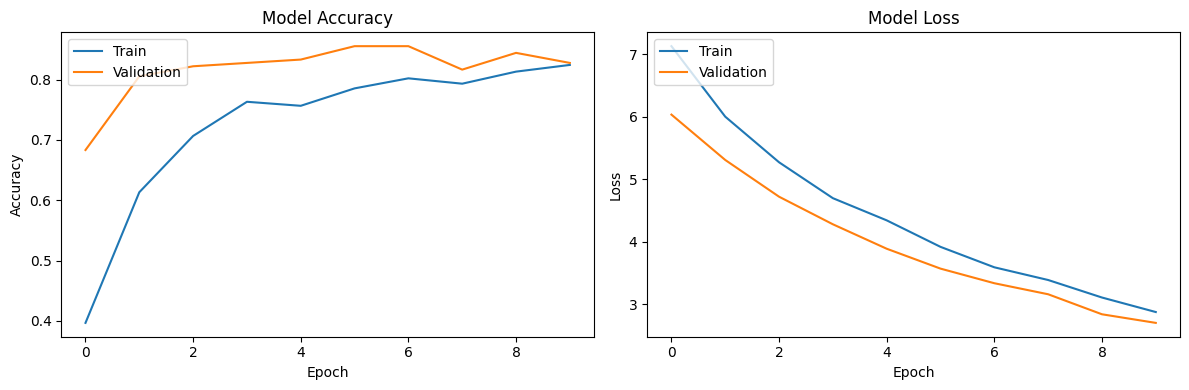

6/6 [==============================] - 5s 733ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.17      0.16        30
           1       0.16      0.17      0.16        30
           2       0.12      0.10      0.11        30
           3       0.22      0.27      0.24        30
           4       0.15      0.13      0.14        30
           5       0.04      0.03      0.03        30

    accuracy                           0.14       180
   macro avg       0.14      0.14      0.14       180
weighted avg       0.14      0.14      0.14       180



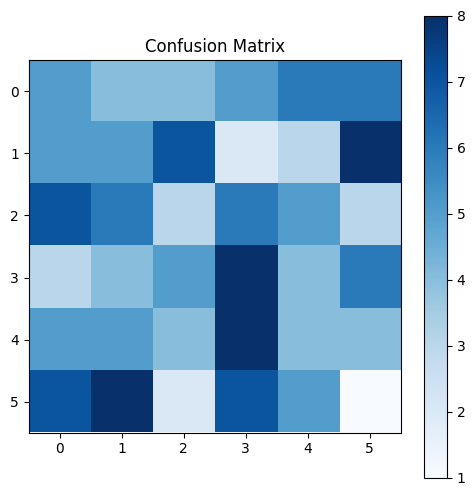

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

plt.show()


the combination of dropout and batch normalization did not improve the model's performance in this case. The test accuracy and classification report show similar or slightly worse results compared to the individual regularization techniques.

#  Visualisation des Caract´eristiques Apprises


## Cartes d’Activation (Activation Maps)

1/1 [==============================] - 4s 4s/step


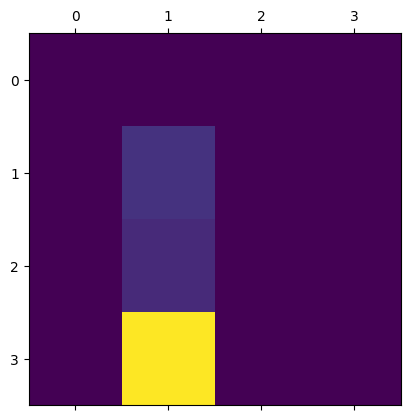

In [28]:
# Assuming you have a MobileNet-based model with a specific layer name
layer_name = 'conv_pw_13_relu'
layer = model.get_layer(layer_name)
activation_model = Model(inputs=model.input, outputs=layer.output)

# Choose an image from the generator
sample_image, _ = train_generator.next()

# Get the activations
activations = activation_model.predict(sample_image)

# Plot the activation map
activation_map = activations[0, :, :, 0]
plt.matshow(activation_map, cmap='viridis')
plt.show()


## Filtres de Convolution

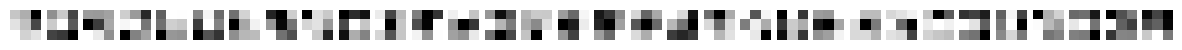

In [32]:
# Assuming the first convolutional layer after MobileNet base
conv_layer = model.layers[1]  # Modify this index based on your model architecture

# Access the weights of the convolutional layer
weights = conv_layer.get_weights()

# Check the number of values in weights
if len(weights) == 2:
    filters, biases = weights
else:
    filters = weights[0]

# Plot the filters with a larger figure size
n_filters = filters.shape[3]
fig, axes = plt.subplots(1, n_filters, figsize=(15, 15))

for i in range(n_filters):
    f = filters[:, :, :, i]
    axes[i].imshow(f[:, :, 0], cmap='gray')
    axes[i].axis('off')

plt.show()


# Analyse Critique

**Techniques Utilisées** :

**Model Architectures**:

Leveraging pre-trained models like MobileNet and VGG16 for transfer learning.
Incorporating techniques like Global Average Pooling, Dropout, Dense layers for classification, and regularization.

**Regularization Techniques**:

Testing different regularization techniques such as Dropout, L1/L2 regularization, and Batch Normalization.
Experimenting with varying dropout rates and regularization strengths.

**Training Strategies**:

Training models using ImageDataGenerator for data augmentation.
Utilizing different optimizers (e.g., Adam) and learning rates during training.
Monitoring model performance with metrics like accuracy and categorical crossentropy loss.

**Fine-Tuning**:

Freezing pre-trained layers and fine-tuning the classification layers for task-specific learning.
Adjusting learning rates for fine-tuning.

**Feature Extraction**:

Creating models for feature extraction using pre-trained architectures.
Adding custom layers for classification on top of the pre-trained models.

**Visualization Techniques**:

Visualizing model architectures using plot_model.
Attempting to visualize filters and activations to understand what the model has learned.

**Défis Rencontrés** :

**Model Convergence**:

Handling issues related to model convergence, especially when using advanced architectures and regularization techniques.

**Hyperparameter Tuning**:

Experimenting with hyperparameters like learning rates and regularization strengths can be challenging and requires fine-tuning for optimal performance.

**Visualization Challenges**:

Facing difficulties in visualizing convolutional filters and activations, potentially due to small filter sizes or complex model architectures.

**Model Interpretability**:

Understanding and interpreting what features the model has learned can be challenging, especially in deep learning models.

**High Execution Time**:

One major challenge encountered is the high execution time during model training, especially with deep architectures and a large number of parameters. This can lead to significant delays in the experimentation and iteration process.

**Intensive Computation**s:

Deep models, especially when based on architectures like VGG16 or MobileNet, may require substantial computational resources. The use of GPUs or cloud services may be necessary to expedite the process.

**Resource Optimization**:

Learning to optimize the use of computational resources, including GPU memory, becomes crucial to reduce execution time and maximize experiment efficiency.

**Parallelization of Computations**:

Exploring techniques for parallelization or distribution of computations may be necessary to reduce training time, especially with large datasets.

**Hardware Dependency**:

Challenges related to the availability of suitable hardware, especially powerful GPUs, can impact execution time and the ability to experiment quickly.

**Apprentissages Tirés** :

**Importance of Regularization**:

Observing the impact of regularization techniques on model performance, including improvements in accuracy and prevention of overfitting.

**Transfer Learning Effectiveness**:

Recognizing the effectiveness of transfer learning in leveraging pre-trained models for improved performance on a specific task.

**Hyperparameter Sensitivity**:

Learning that hyperparameter choices, such as learning rates and dropout rates, significantly influence model performance.

**Data Augmentation Impact**:

Understanding the positive impact of data augmentation in training models, enhancing their ability to generalize to new data.

**Model Evaluation and Interpretation**:

Emphasizing the importance of model evaluation, visualizations, and interpretation techniques for gaining insights into model behavior.

**Fine-Tuning Considerations**:

Acknowledging the need for careful consideration when fine-tuning pre-trained models to balance between leveraging learned features and adapting to task-specific requirements.

**Resource Planning**:

Effective planning and management of hardware resources are critical to optimizing execution time, especially when using cloud services or distributed computing platforms.

**Balance Between Precision and Time**:

Finding the right balance between model accuracy and training time is essential. Sometimes compromises may be necessary to speed up the process.

**Iterative Evaluation**:

Regular iteration and frequent evaluation of models help quickly identify promising approaches, reducing time spent on less effective strategies.

**Use of Lighter Models**:

If execution time remains a challenge, considering the use of lighter models while seeking to maintain acceptable performance can be a valid strategy.

**Efficient Data Generators**:

Optimizing the efficiency of data generators, especially when augmenting data, can contribute to speeding up the training process.

In conclusion, the experimentation with various techniques and the identification of challenges contribute to a deeper understanding of the intricacies involved in training and evaluating deep learning models for image classification tasks. In addition ,managing execution time and computational resources is a crucial aspect of training complex models in deep learning. Optimizing these resources and seeking solutions to reduce execution times are key elements to enhance the overall efficiency of the process. The iterative process of adjusting techniques and learning from challenges provides valuable insights for future model development and improvements.